In [1]:
# Import the required modules
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

# Metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, RocCurveDisplay

# Pre-Processing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#CSV import for crashes table
filepath = "Datasets/crash_records_ml.csv"
df = pd.read_csv(filepath)
df.head()

,Make,Model,Model Year,Incident Date,Incident Time (24:00),City,State,Roadway Type,Roadway Surface,Roadway Description,Posted Speed Limit (MPH),Lighting,Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,Jaguar,I-Pace,2021,January 2024,12:04,Los Angeles,CA,Street,Dry,No Unusual Conditions,25.0,Daylight,1,0,0,0,0,0,1,0
1,Jaguar,I-Pace,2024,July 2024,04:58,San Francisco,CA,Street,Dry,No Unusual Conditions,25.0,Dark - Lighted,1,0,0,0,0,0,0,0
2,Jaguar,I-Pace,2024,July 2024,11:29,Phoenix,AZ,Parking Lot,Dry,No Unusual Conditions,5.0,Daylight,1,0,0,0,0,0,0,1
3,Jaguar,I-Pace,2024,July 2024,18:16,San Francisco,CA,Street,Dry,No Unusual Conditions,25.0,Daylight,1,0,0,0,0,0,0,0
4,Jaguar,I-Pace,2024,July 2024,11:06,Austin,TX,Street,Dry,No Unusual Conditions,40.0,Daylight,0,0,1,0,0,0,0,1


In [3]:
df = df.dropna()

In [4]:
df.columns

Index(['Make', 'Model', 'Model Year', 'Incident Date', 'Incident Time (24:00)',
       'City', 'State', 'Roadway Type', 'Roadway Surface',
       'Roadway Description', 'Posted Speed Limit (MPH)', 'Lighting', 'Clear',
       'Snow', 'Cloudy', 'Fog/Smoke', 'Rain', 'Severe Wind', 'Injuries',
       'Passengers Belted'],
      dtype='object')

In [5]:
cols_to_drop= ['City', 'State','Make','Model', 'Incident Date','Roadway Description','Incident Date','Lighting']
df_ml = df.drop(cols_to_drop, axis=1)
df_ml.head()

,Model Year,Incident Time (24:00),Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Clear,Snow,Cloudy,Fog/Smoke,Rain,Severe Wind,Injuries,Passengers Belted
0,2021,12:04,Street,Dry,25.0,1,0,0,0,0,0,1,0
1,2024,04:58,Street,Dry,25.0,1,0,0,0,0,0,0,0
2,2024,11:29,Parking Lot,Dry,5.0,1,0,0,0,0,0,0,1
3,2024,18:16,Street,Dry,25.0,1,0,0,0,0,0,0,0
4,2024,11:06,Street,Dry,40.0,0,0,1,0,0,0,0,1


In [6]:
#  Dropping the columns with no positive results for the period that was covered by this report.
#  May need to re-instate as more incidents come up
cols_to_drop= ['Severe Wind', 'Fog/Smoke']
df_ml = df_ml.drop(cols_to_drop, axis=1)
df_ml.head()

,Model Year,Incident Time (24:00),Roadway Type,Roadway Surface,Posted Speed Limit (MPH),Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted
0,2021,12:04,Street,Dry,25.0,1,0,0,0,1,0
1,2024,04:58,Street,Dry,25.0,1,0,0,0,0,0
2,2024,11:29,Parking Lot,Dry,5.0,1,0,0,0,0,1
3,2024,18:16,Street,Dry,25.0,1,0,0,0,0,0
4,2024,11:06,Street,Dry,40.0,0,0,1,0,0,1


In [7]:
def categorize_time(incident_time): #X-pert advised
    if isinstance(incident_time, str):
        if "00:00" <= incident_time < "10:00":
            return "Morning"
        elif "10:00" <= incident_time <= "16:00":
            return "Afternoon"
        else:
            return "Night"
    else:
        return None  # or return a default value, e.g., "Unknown"

# Apply the function to the Incident Time column
df_ml['Incident Time (24:00)'] = df_ml['Incident Time (24:00)'].apply(categorize_time)

In [8]:
df_ml['Incident Time (24:00)'].value_counts()

Incident Time (24:00)
Night        472
Afternoon    451
Morning      405
Name: count, dtype: int64

In [9]:
df_ml = df_ml.rename(columns = {'Incident Time (24:00)': "Time of Day"})
df_ml['Time of Day'].value_counts()

Time of Day
Night        472
Afternoon    451
Morning      405
Name: count, dtype: int64

In [10]:
df_ml = df_ml.rename(columns = {'Posted Speed Limit (MPH)': "Speed Limit"})
df_ml['Speed Limit'] = df_ml['Speed Limit'].astype(int)


In [11]:
df_ml.columns

Index(['Model Year', 'Time of Day', 'Roadway Type', 'Roadway Surface',
       'Speed Limit', 'Clear', 'Snow', 'Cloudy', 'Rain', 'Injuries',
       'Passengers Belted'],
      dtype='object')

In [12]:
df_ml['Roadway Type'] = df_ml['Roadway Type'].replace({
    'Unknown': 'Other',
    'Traffic Circle': 'Other',
    'Parking Lot': 'Other'
})

In [13]:
df_ml['Roadway Type'].value_counts()

Roadway Type
Intersection         590
Street               571
Highway / Freeway     99
Other                 68
Name: count, dtype: int64

In [14]:
df_ml['Roadway Surface'] = df_ml['Roadway Surface'].replace({
    'Unknown': 'Wet',
    'Snow / Slush / Ice': 'Wet'
})

In [15]:
df_ml['Roadway Surface'].value_counts()

Roadway Surface
Dry    1261
Wet      67
Name: count, dtype: int64

In [16]:
df_ml.head()

,Model Year,Time of Day,Roadway Type,Roadway Surface,Speed Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted
0,2021,Afternoon,Street,Dry,25,1,0,0,0,1,0
1,2024,Morning,Street,Dry,25,1,0,0,0,0,0
2,2024,Afternoon,Other,Dry,5,1,0,0,0,0,1
3,2024,Night,Street,Dry,25,1,0,0,0,0,0
4,2024,Afternoon,Street,Dry,40,0,0,1,0,0,1


In [17]:
df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1328 entries, 0 to 1361
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Model Year         1328 non-null   int64 
 1   Time of Day        1328 non-null   object
 2   Roadway Type       1328 non-null   object
 3   Roadway Surface    1328 non-null   object
 4   Speed Limit        1328 non-null   int32 
 5   Clear              1328 non-null   int64 
 6   Snow               1328 non-null   int64 
 7   Cloudy             1328 non-null   int64 
 8   Rain               1328 non-null   int64 
 9   Injuries           1328 non-null   int64 
 10  Passengers Belted  1328 non-null   int64 
dtypes: int32(1), int64(7), object(3)
memory usage: 119.3+ KB


In [18]:
df_ml.describe()

,Model Year,Speed Limit,Clear,Snow,Cloudy,Rain,Injuries,Passengers Belted
count,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000,1328.000000
mean,2069.266566,29.847892,0.827560,0.000753,0.128012,0.033133,0.197289,0.648343
std,617.564092,12.588295,0.377905,0.027441,0.334229,0.179050,0.398102,0.477667
min,2016.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2021.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2021.000000,25.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,2023.000000,30.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9999.000000,75.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
features = ['Model Year', 'Time of Day', 'Roadway Type', 'Roadway Surface',
       'Speed Limit', 'Clear', 'Snow', 'Cloudy', 'Rain', 'Passengers Belted']

# We are looking to see if Injuries are resultant from various characteristics, as a result "Injuries" was dropped from the features as it'll be against our test case.

In [20]:
df_ml.columns

Index(['Model Year', 'Time of Day', 'Roadway Type', 'Roadway Surface',
       'Speed Limit', 'Clear', 'Snow', 'Cloudy', 'Rain', 'Injuries',
       'Passengers Belted'],
      dtype='object')

In [21]:
## Need  to do a classificiation model

# Define Preprocessing Pipelines

# Define preprocessing for numeric features (Age, Fare, Family_Size) (note that for age, we just use the column median, not split by gender)
numeric_features = ['Model Year', 'Speed Limit'] # You can also do this in a loop, select the numeric columns
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))])
    # ('scaler', StandardScaler())])

# # Define preprocessing for the binary features ('CryoSleep', 'VIP', 'Side')
binary_features = ['Clear', 'Snow', 'Cloudy', 'Rain', 'Passengers Belted']
binary_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('label', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])  # Label encode for binary feature

# # Define preprocessing for categorical features ('HomePlanet', 'Destination', 'Deck') 
categorical_features = ['Time of Day', 'Roadway Type', 'Roadway Surface']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent', missing_values=pd.NA)),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# # Combine preprocessing for numeric and categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('binary', binary_transformer, binary_features),
        ('cat', categorical_transformer, categorical_features)])

In [22]:
# Use only preprocessing pipeline to transform the data
preprocessed_X_train = preprocessor.fit_transform(df_ml)

# Convert preprocessed data to a DataFrame
# Get the feature names after one-hot encoding
encoded_feature_names = (numeric_features + binary_features +
                         list(preprocessor.transformers_[2][1]['onehot'].get_feature_names_out(categorical_features)))

df_final = pd.DataFrame(preprocessed_X_train, columns=encoded_feature_names)
df_final["Injuries"] = df_ml.Injuries
df_final.head()

,Model Year,Speed Limit,Clear,Snow,Cloudy,Rain,Passengers Belted,Time of Day_Afternoon,Time of Day_Morning,Time of Day_Night,Roadway Type_Highway / Freeway,Roadway Type_Intersection,Roadway Type_Other,Roadway Type_Street,Roadway Surface_Dry,Roadway Surface_Wet,Injuries
0,2021.0,25.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
1,2024.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2,2024.0,5.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,2024.0,25.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,2024.0,40.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [23]:
corrs = df_final.corr()
corrs

,Model Year,Speed Limit,Clear,Snow,Cloudy,Rain,Passengers Belted,Time of Day_Afternoon,Time of Day_Morning,Time of Day_Night,Roadway Type_Highway / Freeway,Roadway Type_Intersection,Roadway Type_Other,Roadway Type_Street,Roadway Surface_Dry,Roadway Surface_Wet,Injuries
Model Year,1.000000,-0.068551,0.009522,-0.002102,-0.000476,-0.014296,-0.004817,0.046315,-0.008913,-0.037253,-0.021814,-0.030424,0.114305,-0.008782,0.017844,-0.017844,0.010375
Speed Limit,-0.068551,1.000000,-0.134621,0.011239,0.163143,0.013940,0.268441,0.101795,-0.049833,-0.052785,0.828161,-0.162614,-0.241535,-0.168636,-0.006887,0.006887,0.035418
Clear,0.009522,-0.134621,1.000000,-0.060138,-0.833400,-0.405532,-0.077354,-0.059895,0.003629,0.055771,-0.189184,0.079189,0.024652,0.009917,0.459428,-0.459428,-0.002492
Snow,-0.002102,0.011239,-0.060138,1.000000,-0.010518,-0.005082,0.020217,0.038280,-0.018184,-0.020384,-0.007791,-0.024545,-0.006377,0.031608,-0.119093,0.119093,0.055999
Cloudy,-0.000476,0.163143,-0.833400,-0.010518,1.000000,-0.020558,0.083933,0.115489,-0.053090,-0.063200,0.217323,-0.047750,-0.037883,-0.050510,-0.107331,0.107331,0.012526
Rain,-0.014296,0.013940,-0.405532,-0.005082,-0.020558,1.000000,-0.031078,-0.035027,0.051003,-0.014403,0.011531,-0.055444,-0.043004,0.068676,-0.803090,0.803090,-0.050359
Passengers Belted,-0.004817,0.268441,-0.077354,0.020217,0.083933,-0.031078,1.000000,0.201791,-0.186954,-0.019828,0.209025,0.071340,-0.057863,-0.156738,0.003163,-0.003163,0.043819
Time of Day_Afternoon,0.046315,0.101795,-0.059895,0.038280,0.115489,-0.035027,0.201791,1.000000,-0.475024,-0.532504,0.111258,-0.071582,0.064252,-0.015790,0.041799,-0.041799,-0.009191
Time of Day_Morning,-0.008913,-0.049833,0.003629,-0.018184,-0.053090,0.051003,-0.186954,-0.475024,1.000000,-0.491882,-0.057238,0.056181,-0.005476,-0.023581,-0.026655,0.026655,0.004437
Time of Day_Night,-0.037253,-0.052785,0.055771,-0.020384,-0.063200,-0.014403,-0.019828,-0.532504,-0.491882,1.000000,-0.055025,0.016785,-0.058304,0.038306,-0.015718,0.015718,0.004838


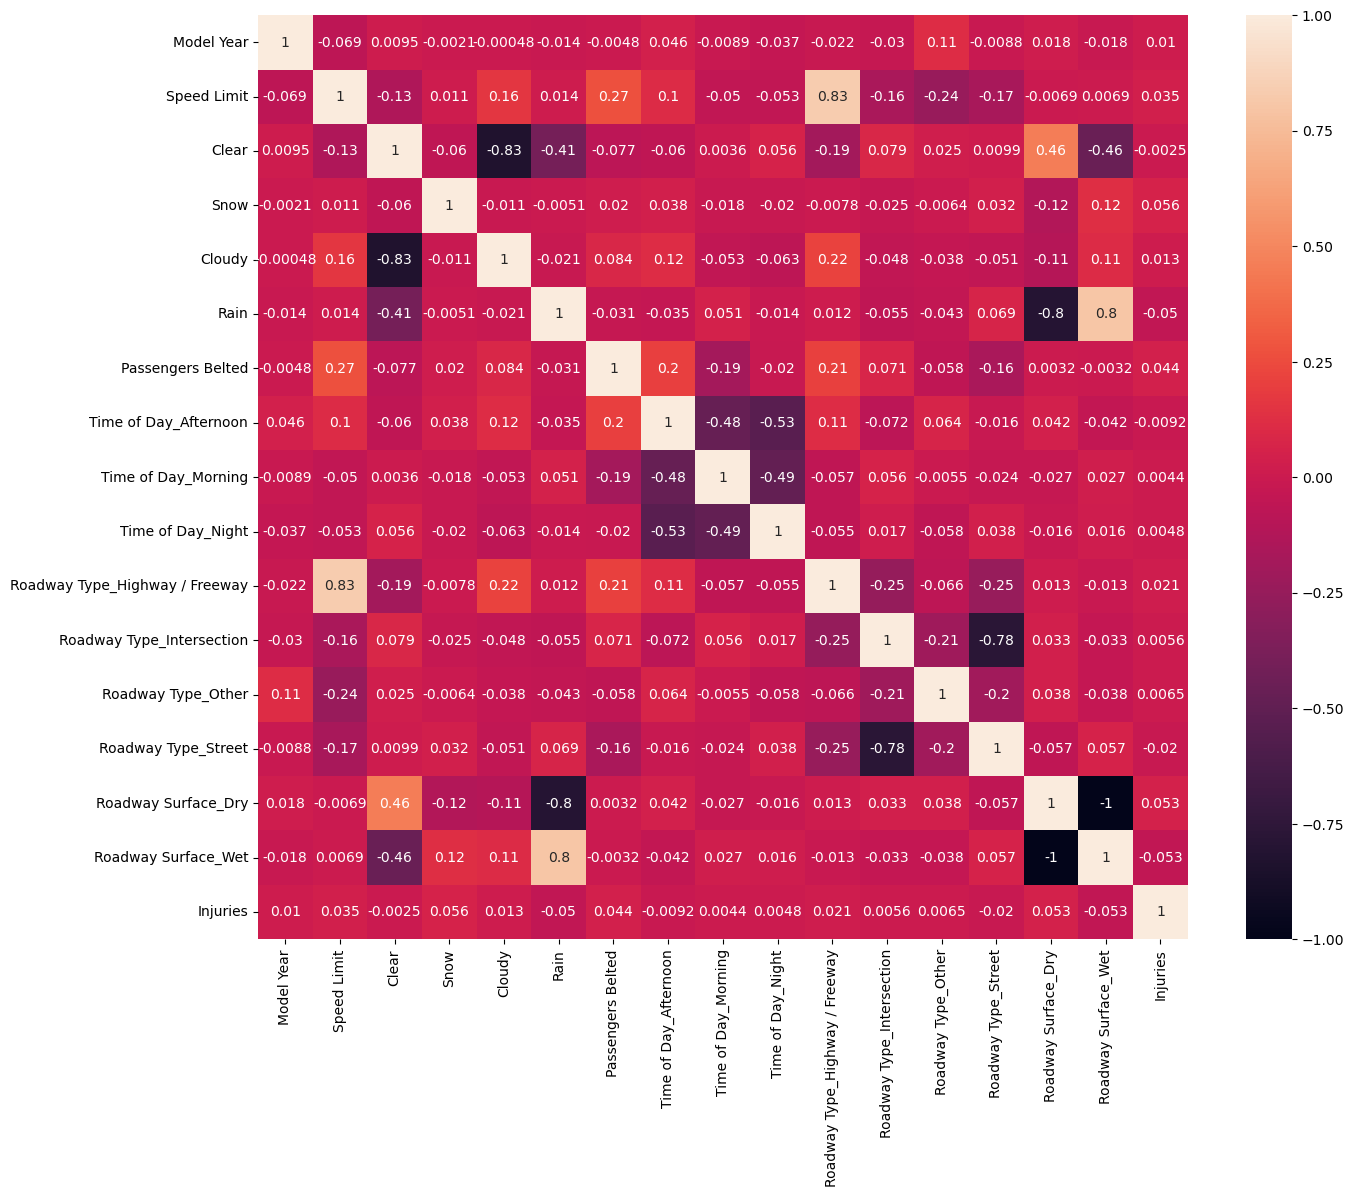

In [24]:
plt.figure(figsize=(15,12))
sns.heatmap(corrs, annot=True)
plt.show()

In [25]:
abs(corrs.Injuries).sort_values(ascending=False)

Injuries                          1.000000
Snow                              0.055999
Roadway Surface_Dry               0.053409
Roadway Surface_Wet               0.053409
Rain                              0.050359
Passengers Belted                 0.043819
Speed Limit                       0.035418
Roadway Type_Highway / Freeway    0.020700
Roadway Type_Street               0.019582
Cloudy                            0.012526
Model Year                        0.010375
Time of Day_Afternoon             0.009191
Roadway Type_Other                0.006522
Roadway Type_Intersection         0.005631
Time of Day_Night                 0.004838
Time of Day_Morning               0.004437
Clear                             0.002492
Name: Injuries, dtype: float64

In [26]:
X = df_ml.drop(columns=["Injuries"])
y = df_ml.Injuries

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1, stratify=y) # stratify=True maintains target class percentages
print(X_train.shape, X_test.shape)

(996, 10) (332, 10)


In [27]:
X_train.head()

,Model Year,Time of Day,Roadway Type,Roadway Surface,Speed Limit,Clear,Snow,Cloudy,Rain,Passengers Belted
66,2024,Afternoon,Street,Dry,25,1,0,0,0,0
1191,2021,Night,Intersection,Dry,25,1,0,0,0,1
1221,2021,Afternoon,Street,Dry,25,1,0,0,0,1
536,2021,Afternoon,Intersection,Dry,25,1,0,0,0,1
765,2023,Morning,Intersection,Dry,25,1,0,0,0,0


In [28]:
def doClassification(model, X_train, X_test, y_train, y_test):
    # Step 3: Fit the model
    model.fit(X_train, y_train)
    
    # Step 4: Evaluate the model
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    train_proba = model.predict_proba(X_train)[:, 1]
    test_proba = model.predict_proba(X_test)[:, 1]

    # Generate metrics TRAIN
    train_cf = confusion_matrix(y_train, train_preds)
    train_cr = classification_report(y_train, train_preds)
    train_auc = roc_auc_score(y_train, train_proba)
    
    train_results = f"""TRAIN METRICS
    Confusion Matrix: 
    {train_cf}
    
    AUC: {train_auc}

    Classification Report:
    {train_cr}
    """
    
    print(train_results)

    # Generate metrics TEST
    test_cf = confusion_matrix(y_test, test_preds)
    test_cr = classification_report(y_test, test_preds)
    test_auc = roc_auc_score(y_test, test_proba)
    
    test_results = f"""TEST METRICS
    Confusion Matrix: 
    {test_cf}
    
    AUC: {test_auc}

    Classification Report:
    {test_cr}
    """
    
    print(test_results)

    # VISUALIZE TEST RESULTS
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(test_cf, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=['Predicted Negative', 'Predicted Positive'], 
                yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test.values, test_proba)
    
    # Set figure size
    plt.figure(figsize=(6, 6))
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {test_auc:.2f})')
    
    # Plot the diagonal reference line
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    
    # Titles and labels
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
    # Add grid and legend
    plt.grid(linestyle="--", color="lightgrey", alpha=0.75)
    plt.legend(loc="lower right")
    
    # Display the plot
    plt.show()

TRAIN METRICS
    Confusion Matrix: 
    [[800   0]
 [196   0]]
    
    AUC: 0.6330963010204083

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       800
           1       0.00      0.00      0.00       196

    accuracy                           0.80       996
   macro avg       0.40      0.50      0.45       996
weighted avg       0.65      0.80      0.72       996

    
TEST METRICS
    Confusion Matrix: 
    [[266   0]
 [ 66   0]]
    
    AUC: 0.6117281840966052

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       266
           1       0.00      0.00      0.00        66

    accuracy                           0.80       332
   macro avg       0.40      0.50      0.44       332
weighted avg       0.64      0.80      0.71       332

    


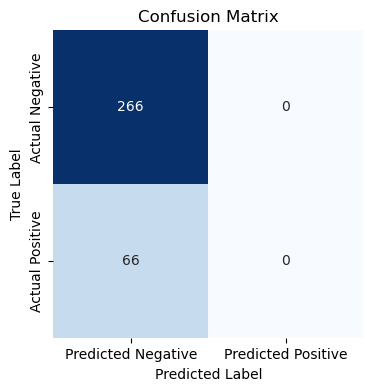

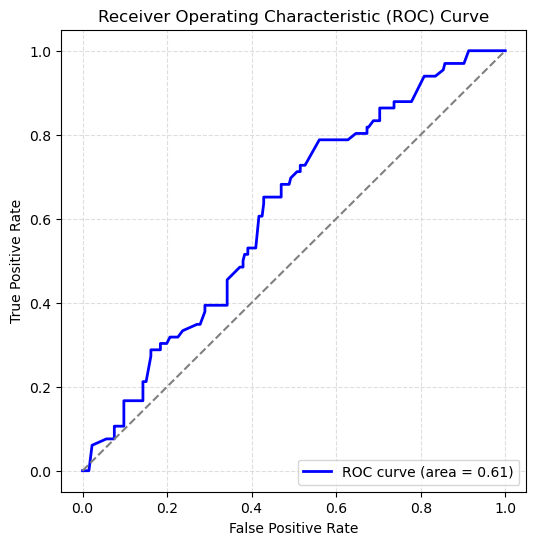

In [29]:
# Step 2: Init the Model
lr = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Do Machine Learning
doClassification(lr, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[785  15]
 [ 80 116]]
    
    AUC: 0.9520822704081634

    Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.98      0.94       800
           1       0.89      0.59      0.71       196

    accuracy                           0.90       996
   macro avg       0.90      0.79      0.83       996
weighted avg       0.90      0.90      0.90       996

    
TEST METRICS
    Confusion Matrix: 
    [[235  31]
 [ 34  32]]
    
    AUC: 0.8211152882205512

    Classification Report:
                  precision    recall  f1-score   support

           0       0.87      0.88      0.88       266
           1       0.51      0.48      0.50        66

    accuracy                           0.80       332
   macro avg       0.69      0.68      0.69       332
weighted avg       0.80      0.80      0.80       332

    


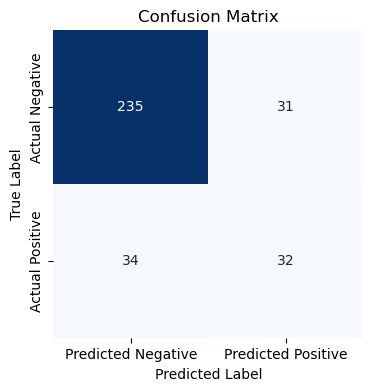

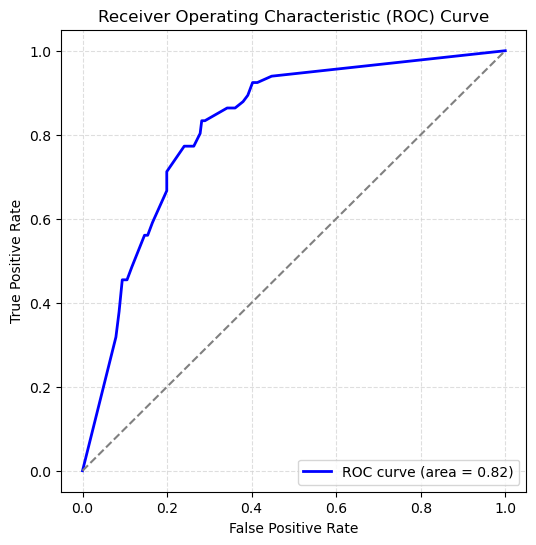

In [30]:
dt = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Do Machine Learning
doClassification(dt, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[776  24]
 [ 71 125]]
    
    AUC: 0.9480644132653061

    Classification Report:
                  precision    recall  f1-score   support

           0       0.92      0.97      0.94       800
           1       0.84      0.64      0.72       196

    accuracy                           0.90       996
   macro avg       0.88      0.80      0.83       996
weighted avg       0.90      0.90      0.90       996

    
TEST METRICS
    Confusion Matrix: 
    [[239  27]
 [ 30  36]]
    
    AUC: 0.8368648894964685

    Classification Report:
                  precision    recall  f1-score   support

           0       0.89      0.90      0.89       266
           1       0.57      0.55      0.56        66

    accuracy                           0.83       332
   macro avg       0.73      0.72      0.73       332
weighted avg       0.83      0.83      0.83       332

    


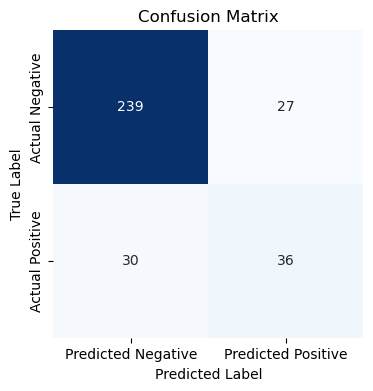

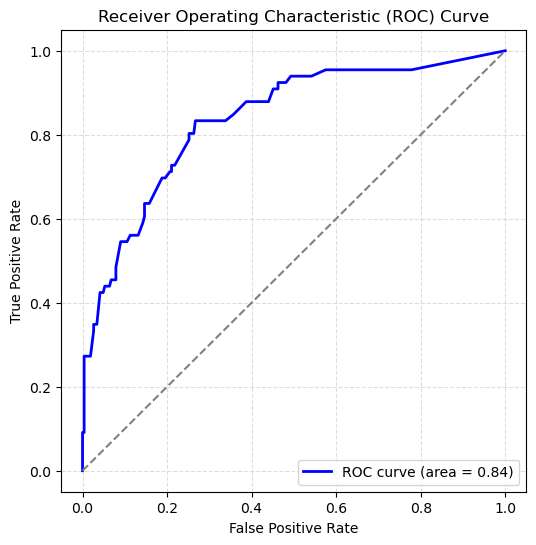

In [31]:
# Step 2: Init the Model
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Do Machine Learning
doClassification(rf, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[800   0]
 [196   0]]
    
    AUC: 0.5483769132653061

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       800
           1       0.00      0.00      0.00       196

    accuracy                           0.80       996
   macro avg       0.40      0.50      0.45       996
weighted avg       0.65      0.80      0.72       996

    
TEST METRICS
    Confusion Matrix: 
    [[266   0]
 [ 66   0]]
    
    AUC: 0.4568523581681476

    Classification Report:
                  precision    recall  f1-score   support

           0       0.80      1.00      0.89       266
           1       0.00      0.00      0.00        66

    accuracy                           0.80       332
   macro avg       0.40      0.50      0.44       332
weighted avg       0.64      0.80      0.71       332

    


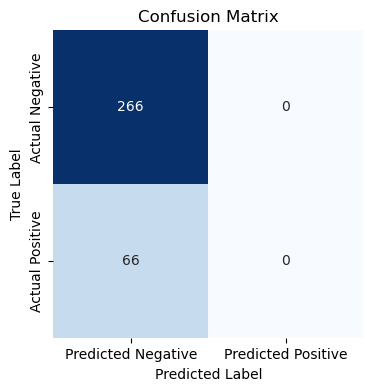

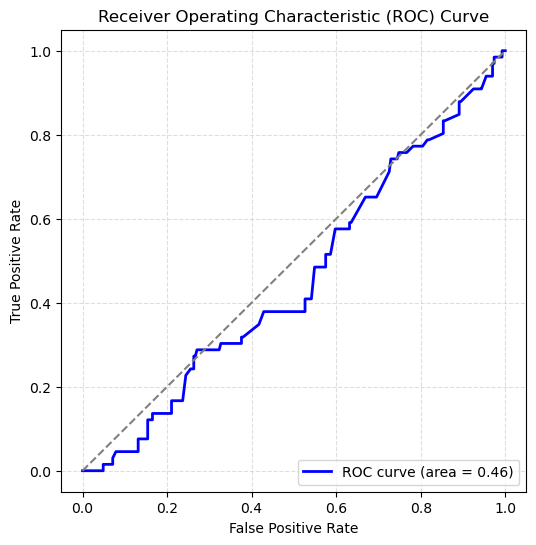

In [32]:
# Step 2: Init the Model
svc = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', SVC(probability=True))
])

# Do Machine Learning
doClassification(svc, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[783  17]
 [154  42]]
    
    AUC: 0.8009948979591837

    Classification Report:
                  precision    recall  f1-score   support

           0       0.84      0.98      0.90       800
           1       0.71      0.21      0.33       196

    accuracy                           0.83       996
   macro avg       0.77      0.60      0.62       996
weighted avg       0.81      0.83      0.79       996

    
TEST METRICS
    Confusion Matrix: 
    [[253  13]
 [ 54  12]]
    
    AUC: 0.7173615857826385

    Classification Report:
                  precision    recall  f1-score   support

           0       0.82      0.95      0.88       266
           1       0.48      0.18      0.26        66

    accuracy                           0.80       332
   macro avg       0.65      0.57      0.57       332
weighted avg       0.76      0.80      0.76       332

    


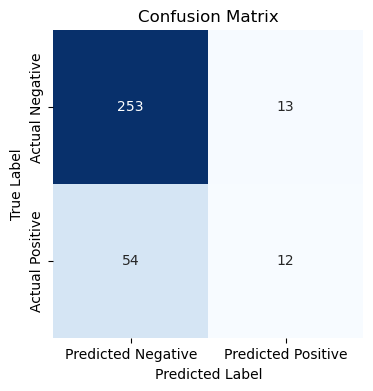

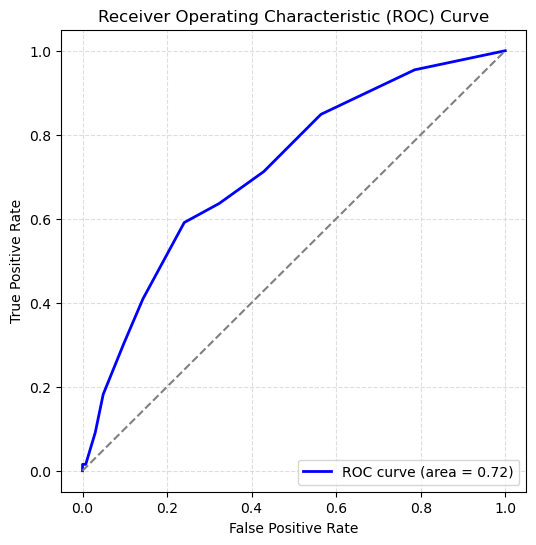

In [33]:
# Step 2: Init the Model
knn = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=15))
])

# Do Machine Learning
doClassification(knn, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[785  15]
 [ 80 116]]
    
    AUC: 0.9520822704081634

    Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.98      0.94       800
           1       0.89      0.59      0.71       196

    accuracy                           0.90       996
   macro avg       0.90      0.79      0.83       996
weighted avg       0.90      0.90      0.90       996

    
TEST METRICS
    Confusion Matrix: 
    [[240  26]
 [ 34  32]]
    
    AUC: 0.8326782866256552

    Classification Report:
                  precision    recall  f1-score   support

           0       0.88      0.90      0.89       266
           1       0.55      0.48      0.52        66

    accuracy                           0.82       332
   macro avg       0.71      0.69      0.70       332
weighted avg       0.81      0.82      0.81       332

    


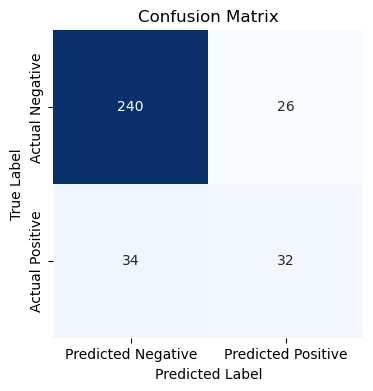

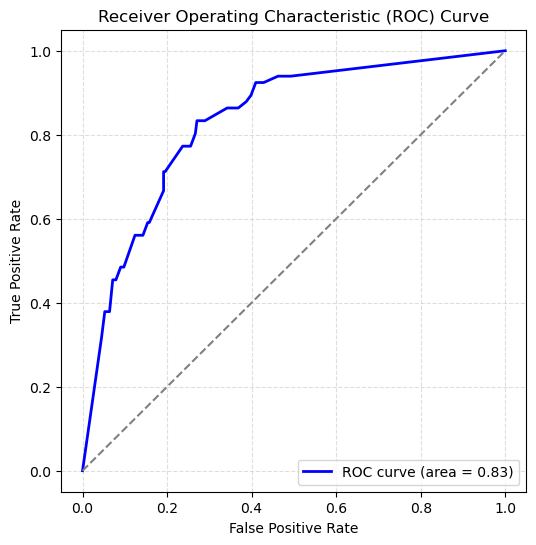

In [34]:
# Step 2: Init the Model
et = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', ExtraTreesClassifier(random_state=42))
])

# Do Machine Learning
doClassification(et, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[779  21]
 [163  33]]
    
    AUC: 0.7738584183673469

    Classification Report:
                  precision    recall  f1-score   support

           0       0.83      0.97      0.89       800
           1       0.61      0.17      0.26       196

    accuracy                           0.82       996
   macro avg       0.72      0.57      0.58       996
weighted avg       0.78      0.82      0.77       996

    
TEST METRICS
    Confusion Matrix: 
    [[259   7]
 [ 60   6]]
    
    AUC: 0.735617452722716

    Classification Report:
                  precision    recall  f1-score   support

           0       0.81      0.97      0.89       266
           1       0.46      0.09      0.15        66

    accuracy                           0.80       332
   macro avg       0.64      0.53      0.52       332
weighted avg       0.74      0.80      0.74       332

    


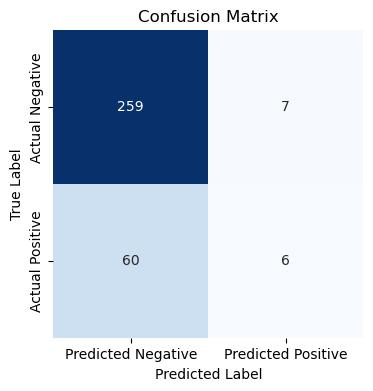

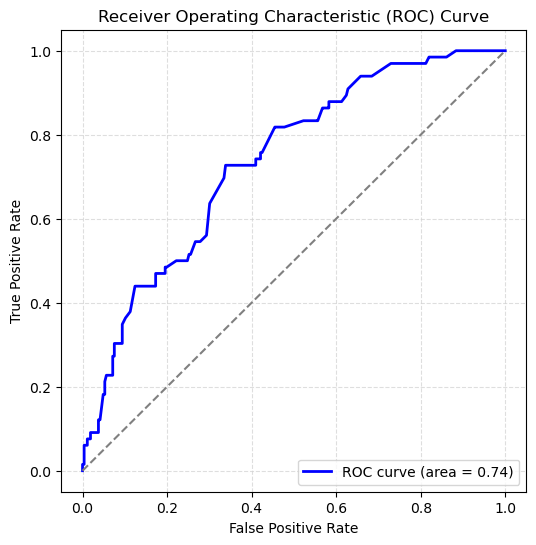

In [35]:
# Step 2: Init the Model
ada = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', AdaBoostClassifier(random_state=42))
])

# Do Machine Learning
doClassification(ada, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[793   7]
 [136  60]]
    
    AUC: 0.8560841836734694

    Classification Report:
                  precision    recall  f1-score   support

           0       0.85      0.99      0.92       800
           1       0.90      0.31      0.46       196

    accuracy                           0.86       996
   macro avg       0.87      0.65      0.69       996
weighted avg       0.86      0.86      0.83       996

    
TEST METRICS
    Confusion Matrix: 
    [[251  15]
 [ 50  16]]
    
    AUC: 0.7787935748462064

    Classification Report:
                  precision    recall  f1-score   support

           0       0.83      0.94      0.89       266
           1       0.52      0.24      0.33        66

    accuracy                           0.80       332
   macro avg       0.68      0.59      0.61       332
weighted avg       0.77      0.80      0.77       332

    


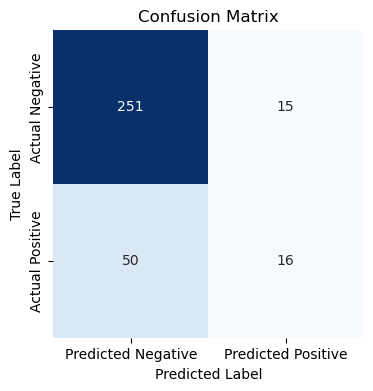

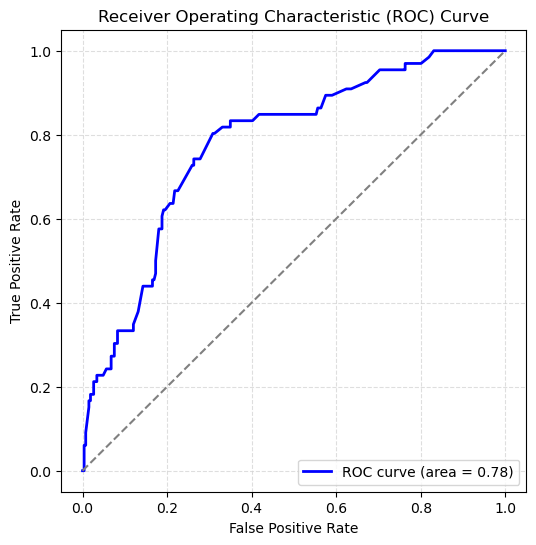

In [36]:
# Step 2: Init the Model
gb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

# Do Machine Learning
doClassification(gb, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[777  23]
 [ 79 117]]
    
    AUC: 0.9381951530612245

    Classification Report:
                  precision    recall  f1-score   support

           0       0.91      0.97      0.94       800
           1       0.84      0.60      0.70       196

    accuracy                           0.90       996
   macro avg       0.87      0.78      0.82       996
weighted avg       0.89      0.90      0.89       996

    
TEST METRICS
    Confusion Matrix: 
    [[240  26]
 [ 31  35]]
    
    AUC: 0.8388300296195034

    Classification Report:
                  precision    recall  f1-score   support

           0       0.89      0.90      0.89       266
           1       0.57      0.53      0.55        66

    accuracy                           0.83       332
   macro avg       0.73      0.72      0.72       332
weighted avg       0.82      0.83      0.83       332

    


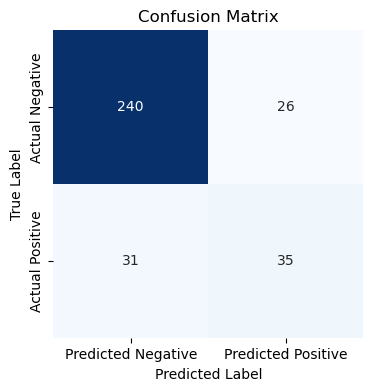

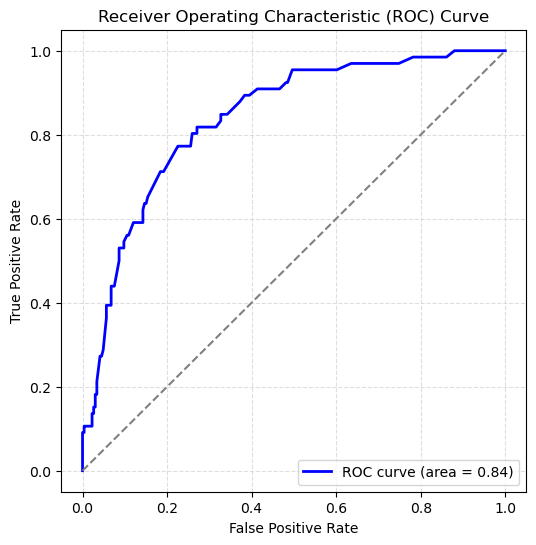

In [37]:
# Step 2: Init the Model
xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(random_state=42))
])

# Do Machine Learning
doClassification(xgb, X_train, X_test, y_train, y_test)

TRAIN METRICS
    Confusion Matrix: 
    [[775  25]
 [ 86 110]]
    
    AUC: 0.9241645408163266

    Classification Report:
                  precision    recall  f1-score   support

           0       0.90      0.97      0.93       800
           1       0.81      0.56      0.66       196

    accuracy                           0.89       996
   macro avg       0.86      0.76      0.80       996
weighted avg       0.88      0.89      0.88       996

    
TEST METRICS
    Confusion Matrix: 
    [[240  26]
 [ 32  34]]
    
    AUC: 0.8294315333789017

    Classification Report:
                  precision    recall  f1-score   support

           0       0.88      0.90      0.89       266
           1       0.57      0.52      0.54        66

    accuracy                           0.83       332
   macro avg       0.72      0.71      0.72       332
weighted avg       0.82      0.83      0.82       332

    


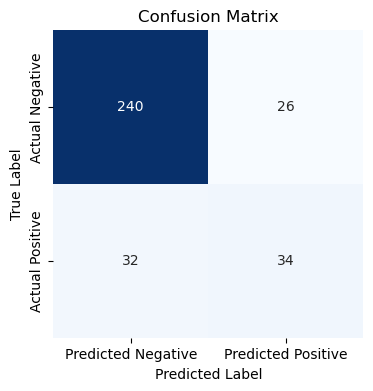

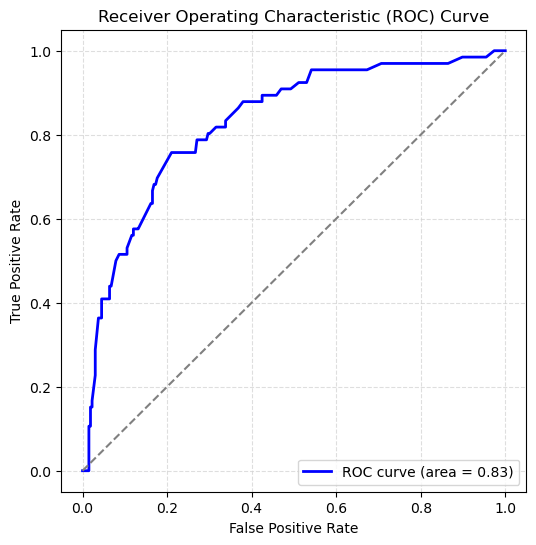

In [38]:
# Step 2: Init the Model
lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LGBMClassifier(random_state=42, verbose=-1))
])

# Do Machine Learning
doClassification(lgbm, X_train, X_test, y_train, y_test)

In [39]:
fi = pd.DataFrame(list(zip(X.columns, gb.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
1,Time of Day,0.293827
0,Model Year,0.262861
6,Snow,0.067516
8,Rain,0.048478
9,Passengers Belted,0.047070
2,Roadway Type,0.034770
4,Speed Limit,0.029396
7,Cloudy,0.022982
5,Clear,0.007266
3,Roadway Surface,0.000000


In [40]:
fi = pd.DataFrame(list(zip(X.columns, xgb.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
5,Clear,0.143797
2,Roadway Type,0.086807
6,Snow,0.075052
0,Model Year,0.064538
9,Passengers Belted,0.064381
7,Cloudy,0.063722
1,Time of Day,0.061361
8,Rain,0.056963
4,Speed Limit,0.032788
3,Roadway Surface,0.000000


In [41]:
fi = pd.DataFrame(list(zip(X.columns, lgbm.named_steps['classifier'].feature_importances_ / sum(lgbm.named_steps['classifier'].feature_importances_))), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,Model Year,0.269115
1,Time of Day,0.263439
7,Cloudy,0.082805
8,Rain,0.067780
6,Snow,0.059766
9,Passengers Belted,0.059766
2,Roadway Type,0.019032
4,Speed Limit,0.018030
5,Clear,0.000668
3,Roadway Surface,0.000000


In [42]:
fi = pd.DataFrame(list(zip(X.columns, ada.named_steps['classifier'].feature_importances_)), columns=["Feature", "Importance"])
fi.sort_values(by="Importance", ascending=False)

,Feature,Importance
0,Model Year,0.52
1,Time of Day,0.32
6,Snow,0.04
5,Clear,0.02
8,Rain,0.02
9,Passengers Belted,0.02
2,Roadway Type,0.00
3,Roadway Surface,0.00
4,Speed Limit,0.00
7,Cloudy,0.00


In [43]:
# # Create a pipeline with a scaler and a logistic regression model
# lr = Pipeline([
#     ('preprocessor', preprocessor),
#     ('classifier', LogisticRegression())
# ])

# # Perform 5-fold cross-validation with roc_auc scoring
# cv = StratifiedKFold(n_splits=5)
# cv_scores = cross_val_score(lr, X, y, cv=cv, scoring='roc_auc')

# # Output the results
# print(f"Cross-validation AUC scores: {cv_scores}")
# print(f"Mean AUC: {np.mean(cv_scores):.3f}")